In [1]:
import datetime
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

matplotlib.rcParams['figure.figsize'] = [9, 6]


def project_xy(angle:float, length:float):
    return math.cos(angle) * length, math.sin(angle) * length

def angle_length(x:float, y:float):
    length = math.sqrt(x**2 + y**2)
    if length == 0:
        return 0,0
    angle = math.atan2(y/length,x/length)
    return angle, length

def v_length(x,y):
    return math.sqrt(x**2 + y**2)

In [1]:
# RK4 – “classical” 4-th order Runge–Kutta (error 𝑂(dt⁴))
# For a physics simulation that is updated, say, 10–30 Hz, semi-implicit Euler is
# often good enough. If you ever need larger dt (e.g. because you want to
# compute a 2-hour patrol in one second of real time) RK4 buys you much more
# accuracy for only 3 extra derivative evaluations.

In [3]:
import math
import datetime as dt
from dataclasses import dataclass, field
from typing import Tuple

Vector = Tuple[float, float]  # convenience alias

SECONDS_PER_HOUR = 3600.0
SECONDS_PER_SECOND = 36.0
KNOT_IN_M_PER_S  = 0.514444  # 1 kn ≈ 0.514 m/s
NM_IN_M          = 1852.0

def norm(v: Vector) -> float:
    """Euclidean norm of a 2-tuple."""
    x, y = v
    return math.hypot(x, y)

def angle(v: Vector) -> float:
    """Angle of a 2-tuple, in radians from North (y-axis up)."""
    x, y = v
    return math.atan2(x, y)          # swap so 0 = North, CCW positive

def vec_from_angle(theta: float, length: float = 1.0) -> Vector:
    """Return vector of given length pointing to theta (0 = North)."""
    # undo the swap done in angle()
    return (math.sin(theta) * length,
            math.cos(theta) * length)
    

def derivatives(s: Tuple[float, ...],
                rudder: float,
                throttle: float,
                max_acc_kn_s: float,
                drag_coeff: float ) -> Tuple[float, ...]:
    """
    Return ds/dt for the submarine.
    s = (x, y, vx, vy, psi)
    rudder  : rad / s   (be careful, convert from your rad/min input)
    throttle: -100 .. +100 (percent)
    """
    x, y, vx, vy, psi = s

    # -- 1. turning --------------------
    dpsi = rudder                         # rad/s

    # -- 2. thrust ---------------------
    ax_thrust = vec_from_angle(psi, max_acc_kn_s * throttle / 100)

    # -- 3. drag -----------------------
    speed = math.hypot(vx, vy)
    if speed == 0.0:
        ax_drag, ay_drag = 0.0, 0.0
    else:
        drag = cfg.drag_coeff * speed * speed        # kn/s
        ax_drag = -drag * vx / speed
        ay_drag = -drag * vy / speed

    ax = ax_thrust[0] + ax_drag
    ay = ax_thrust[1] + ay_drag

    # -- assemble derivative -----------
    return (
        vx,             # dx/dt
        vy,             # dy/dt
        ax,             # dvx/dt
        ay,             # dvy/dt
        dpsi            # dpsi/dt
    )


@dataclass
class Submarine:
    # --- configuration constants ---
    max_turn_rate_deg_min: float = 120.0             # deg/min
    max_speed_kn:          float = 36.0              # knots
    max_acc_kn_s:          float = 2.0               # knots/second  (throttle 100 %)
    drag_coeff:            float = 1.0               # tuned to taste

    # --- inputs (controls) ---
    rudder_rad_sec:  float = 0.0                     # radians/second (+ = port / CCW)
    throttle_pct:    float = 0.0                     # −100 … +100 %

    # --- state (updated every tick) ---
    pos_nm:   Vector = (0.0, 0.0)                    # position in nautical miles
    vel_kn:   Vector = (0.0, 0.0)                    # velocity in knots
    heading:  float  = 0.0                           # ship's bow direction (rad)
    clock:    dt.datetime = field(default_factory=lambda: dt.datetime(2022, 1, 1))

    # --------------------------------------------------------------------- #
    # public API                                                             #
    # --------------------------------------------------------------------- #

    def step2(self, dt_seconds: float) -> None:
        # convert rudder from rad/min to rad/s expected by derivative()
        rudder_rate = self.rudder_rad_sec

        # build current state tuple
        state = (*self.pos_nm, *self.vel_kn, self.heading)

        # one RK4 advance
        state = rk4_step(state, dt_seconds, rudder_rate, self.throttle_pct, self)

        # unpack back into object fields
        (x, y, vx, vy, psi) = state
        self.pos_nm = (x, y)
        self.vel_kn = (vx, vy)
        self.heading = psi % math.tau
        self.clock += dt.timedelta(seconds=dt_seconds)

        
    def step(self, dt_seconds: float) -> None:
        """Advance simulation by dt_seconds."""
        if dt_seconds <= 0:
            return

        # ----------------- convert constants to per-second ----------------
        max_turn_rate = math.radians(self.max_turn_rate_deg_min) / 60.0  # rad/s
        max_speed     = self.max_speed_kn
        max_acc       = self.max_acc_kn_s

        # ----------------- 1. heading update (rudder) ---------------------
        target_yaw_rate = max_turn_rate * self.rudder_rad_sec 
        self.heading += target_yaw_rate * dt_seconds
        self.heading = (self.heading + math.tau) % math.tau  # wrap 0…2π

        # ----------------- 2. thrust from turbines ------------------------
        thrust = max_acc * (self.throttle_pct / 100.0)       # kn/s
        thrust_vec = vec_from_angle(self.heading, thrust)

        # ----------------- 3. hydrodynamic drag ---------------------------
        speed = norm(self.vel_kn)
        drag_mag = self.drag_coeff * speed * speed           # kn/s opposite to vel
        drag_vec = (0.0, 0.0) if speed == 0 else tuple(
            -drag_mag * c / speed for c in self.vel_kn
        )

        # ----------------- 4. integrate velocity --------------------------
        ax, ay = (thrust_vec[0] + drag_vec[0],
                  thrust_vec[1] + drag_vec[1])
        self.vel_kn = (self.vel_kn[0] + ax * dt_seconds,
                       self.vel_kn[1] + ay * dt_seconds)

        # clamp to physical max speed
        speed = norm(self.vel_kn)
        if speed > max_speed:
            scale = max_speed / speed
            self.vel_kn = (self.vel_kn[0] * scale, self.vel_kn[1] * scale)

        # ----------------- 5. integrate position --------------------------
        self.pos_nm = (self.pos_nm[0] + self.vel_kn[0] * dt_seconds / SECONDS_PER_HOUR,
                       self.pos_nm[1] + self.vel_kn[1] * dt_seconds / SECONDS_PER_HOUR)

        # ----------------- 6. update wall clock ---------------------------
        self.clock += dt.timedelta(seconds=dt_seconds)

    # helper for display / logging
    def pretty_state(self) -> str:
        north, east = self.pos_nm[1], self.pos_nm[0]
        speed = norm(self.vel_kn)
        return (f"t={self.clock.time()}  pos=({east:.3f} E, {north:.3f} N) nm  "
                f"spd={speed:.2f} kn  hdg={math.degrees(self.heading):.1f}°")
        

        
    # def debug_pos(self):
    #     return f'{self.time.strftime("%H:%m:%S")} t_level: {self.turbine_level:0.2f} t_acc:{self.turbine_acc:0.2f} drag:{self.drag:0.2f}({self.drag_x:0.2f},{self.drag_y:0.2f}) acc:{self.acceleration:0.2f} speed:{self.speed:0.2f} pos:({self.position_x:0.2f},{self.position_y:0.2f})'

In [3]:
# world = World()

# for i in range(1000):
    
#     world.turn(1/3600)
#     print(world.debug_pos())




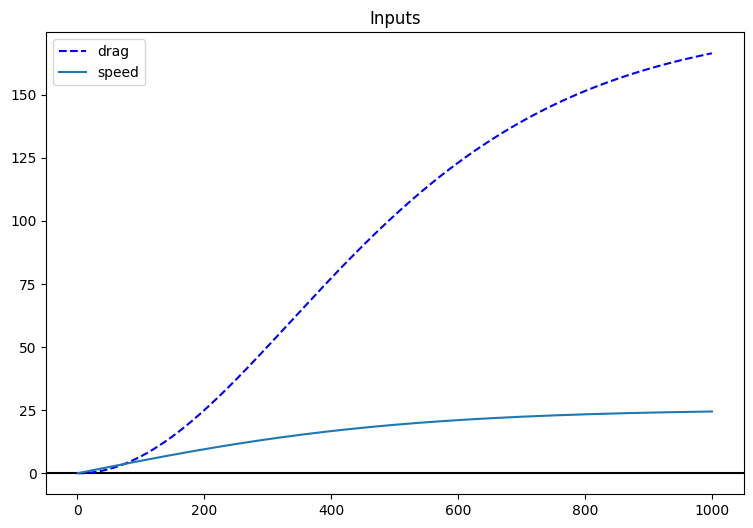

In [4]:
submarine = Submarine()

speed = []
drag = []
for i in range(1000):
    submarine.step(1/60)  # advance time in 1/60 of a second (60 fps)
    speed.append(submarine.speed)
    drag.append(submarine.drag)
    
    
    

    
x = np.linspace(1, len(speed), len(speed))
plt.axhline(y = 0, color = 'black', linestyle = '-')

plt.plot(x, drag, color = 'b', linestyle = '--', label = 'drag') 
plt.plot(x, speed, label = 'speed')
# plt.plot(x, outputs, linestyle = '-.', color = 'green')
plt.legend()


plt.title('Inputs')
plt.show()

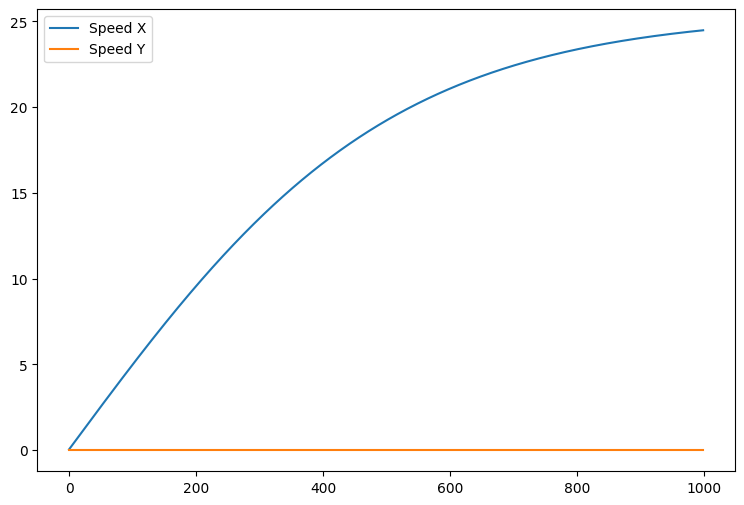

In [5]:

world = World()

world.rudder = 2.0

x = []
speed_x = []
speed_y = []
for i in range(1000):
    x.append(i)
    world.turn(1/3600)
    speed_x.append(world.speed_x)
    speed_y.append(world.speed_y)
#     print(world.debug_pos())
    
plt.plot(x, speed_x, label='Speed X')
plt.plot(x, speed_y, label='Speed Y')
# plt.title('Inputs')
plt.legend()
plt.show()

In [36]:
power = 10
angle = math.radians(30.0)
print(angle,power)

x, y = project_xy(angle, power)
print(x,y)

a, p = angle_length(x,y)
print(a,p)

0.5235987755982988 10
8.660254037844387 4.999999999999999
0.5235987755982987 10.0
